Here we analyze the raw data obtained from the _QPC_dd_sim.py_ script.

In [5]:
import numpy as np
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import json
import matplotlib 
import os

from ast import literal_eval

from qutip import  *


In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 18

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/QPC_double_dot/"


In [3]:
def load_data(dir_route, file):
    # loading the simulation data
    with h5py.File(dir_route+file, 'r') as res_h5:
        Param_dict = json.loads(res_h5['metadata/parameters'][()])

        # load qpc data
        N_bond = res_h5["results/QPC_bond_density"][:]
        N_left = res_h5["results/QPC_left_density"][:]
        N_right = res_h5["results/QPC_right_density"][:]
        N_last = res_h5["results/QPC_last_site_density"][:]

        # load dot data
        N_d1 = res_h5["results/d1_density"][:]
        N_d2 = res_h5["results/d2_density"][:]

        # time range
        Times = res_h5["results/time"][:]
        
        # trajectories
        Trajectories = res_h5["results/trajectories"][:]

    res_h5.close()
    
    return Param_dict,Times, N_bond, N_left, N_right, N_last, N_d1, N_d2,Trajectories
    

def get_timescale_data(Param_dict, Traject, Times, N_bond):
    # calculates the quantities relevant to the estimation of the hitting time
    # including the time it takes to hit the different parts of the QPC
    J = 1
    
    QPC_traject = Traject[0:-2,:] # we only care about qpc trajectories for now
    # vector holding distance to origin of each lattice site
    r_vect = np.arange(0,Param_dict["L_qpc"])
    # position average in time
    x_av = np.asarray([np.dot(QPC_traject[:,i],r_vect) for i in range(0,len(Times)) ])

    # trajectory using Ehrenfest Therem
    vg = 2*J*np.sin(Param_dict["k0"])
    
    # time to get to the bond which is between [bond_index and bond_index+1]
    tau_0b = (Param_dict["bond_index"]-1)/vg

    # time at the bond defined at width at half maximum of the bond occupation
    # estimate FWHF with an interpolation
    spline = UnivariateSpline(Times, N_bond-np.max(N_bond)/2, s=0)
    bond_root = spline.roots() # find the roots
    # the first two roots yield the width at half maximum
    tau_b= bond_root[1] - bond_root[0]

    #time from bond to the wall
    tau_bL = (Param_dict["L_qpc"]-Param_dict["bond_index"]-2)/vg
    # total time
    tau_L = tau_0b + tau_b + tau_bL

    # time if there were no potential at bond
    tau_free = Param_dict["L_qpc"]/vg
    
    return tau_L, tau_free, tau_b, vg, x_av, bond_root 


def get_transmision_proba(Param_dict, J):
    # in the limit where we have very localized state the transmision probability is approximately that of the
    # one for K0
    V0 = J - 2*(Param_dict["Omega"] + Param_dict["J_prime"])
    T0 = 1/(1+(V0/Param_dict["k0"])**2)

    # the momentum distribution
    k_arr = np.linspace(-200,200, 5000)
    Psi0k_abs = (Param_dict["band_width"]**2/np.pi)**(1/2)*np.exp(-(Param_dict["band_width"]**2)*(k_arr-Param_dict["k0"])**2)
    # now with the wave packet weights
    T_k = 1/(1+(V0/k_arr)**2)
    T_tot = simpson(T_k*Psi0k_abs, dx=k_arr[1] - k_arr[0])
    
    return T0, T_tot
    
def find_nearest_index(array, value):
    # finds the index of the element closest to value
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx


def get_partial_trace(Psi,NN):
    # calcualtes the partial trace from a STATEVECTOR Psi
    # NOT from the density matrix
    # Psi: Quobject from Qutip representing the wavefunction
    # NN: integer with the total size of the lattice

    n = 2**(NN-2) # QPC sites
    m = 2**2 # Double dot sites
    # get density matrix as a sparse array
    ps = sparse.csr_matrix(Psi.full())
    A = sparse.kron(ps, np.conj(ps.T))
    # convert to normal array for partial trace operation
    Adense = A.toarray()
    # trace out QPC sites and return reduced rho for DD as Quobject
    return Qobj(np.trace(Adense.reshape(n,m,n,m), axis1=0, axis2=2))

def get_entanglement(States, L ,tskip=5):
    # calculates several entanglement measures
    # States: list of Quobj containing the time evolution of the wavefunction
    # tskip: tells how many in between times to skip for faster computation
    purity_list = []
    entropy_list = []
    # skip some times otherwise its too heavy

    state_arr = States[0::tskip]
    for ti in range(0,len(state_arr)):
        # DD reduced density matrix
        rho_DD = get_partial_trace(state_arr[ti], L)
        # purity
        purity_list.append((rho_DD**2).tr())
        entropy_list.append(entropy_vn(rho_DD, sparse=False))
        
    return purity_list, entropy_list, tskip


In [4]:
data_route = "../data/sims/"
wave_function_route = "../data/sims/wavefunctions/"


# Dataframe summary

data_dict = {'L_qpc': [],'max_time': [],'tsteps': [],'bond_index': [],
             'band_width': [],'k0': [],'J_prime': [],'t': [],'Omega': [],
            "vg":[],'time_at_bond':[], "time_f_free":[], "time_f_int": [], 
            "xf_avg_free":[], "xf_avg_int":[], "Transmision_tot":[],"Transmission_k0":[],
            "r_density_free":[], "r_density_int":[], "last_density_free":[],"last_density_int":[],
            "last_density_max":[], "time_last_density_max":[], "purity":[], "VN_entropy":[],
            "entanglement_timeskip":[], "T_mean":[]}

file_list = os.listdir(data_route)
file_list.remove('.DS_Store')
file_list.remove('wavefunctions')


wavefile_list = os.listdir(wave_function_route)
wavefile_list.remove('.DS_Store')

J=1

for i in range(0,len(file_list)):

    file_ = file_list[i]
    wavefile_ = wavefile_list[i]
    wavefile_ = wavefile_.removesuffix('.qu')    # removes .qu suffix so qutip can load it
    
    if(i%10==0):
        print(file_)
    
    # Load observables
    param_dict, times, n_bond, n_left, n_right, n_last, n_d1, n_d2, traject = load_data(data_route,file_)
    
    # bw =3.0 causes problems sinces its super delocalized in space so skip
    if(param_dict["band_width"]==3.0):
        continue

    # calculate data for the time scales
    tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)   
    
    # find time index nearest to the hitting time with interaction
    time_f_i = find_nearest_index(times, tau_L)
    xf_avg_int = x_av[time_f_i]
    r_density_int = n_right[time_f_i]
    last_density_int = n_last[time_f_i]

    # find time index nearest to the hitting time in the free case
    time_f_i = find_nearest_index(times, tau_free)
    xf_avg_free = x_av[time_f_i]
    r_density_free = n_right[time_f_i]
    last_density_free = n_last[time_f_i]

    # get transmision probabilities from scattering analytics
    T0, T_tot = get_transmision_proba(param_dict, J)
    # average over the numerical transmision rate (n right) 
    # for the final times (time in tending to infinity)
    # find the index corresponding to t=6
    start_time = find_nearest_index(times, 6.0)
    T_mean = np.mean(n_right[start_time:])

    # get the maximum of the density in the last site and the time
    n_max = n_last.max()
    time_last_density_max = times[n_last.argmax()]
    
    # load wavefunctions
    wavefunction_time = qload(wave_function_route+wavefile_)
    
    # calculate entanglement measures
    purity, VN_entorpy, tskip = get_entanglement(wavefunction_time,param_dict["L_qpc"]+2, tskip=10)
    
    data_dict["vg"].append(vg)
    data_dict["time_at_bond"].append(tau_b)

    data_dict["time_f_int"].append(tau_L)
    data_dict["xf_avg_int"].append(xf_avg_int)
    data_dict["r_density_int"].append(r_density_int)
    data_dict["last_density_int"].append(last_density_int)

    data_dict["time_f_free"].append(tau_free)
    data_dict["xf_avg_free"].append(xf_avg_free)
    data_dict["r_density_free"].append(r_density_free)
    data_dict["last_density_free"].append(last_density_free)

    data_dict["Transmision_tot"].append(T_tot)
    data_dict["Transmission_k0"].append(T0)
    data_dict["T_mean"].append(T_mean)

    data_dict["last_density_max"].append(n_max)
    data_dict["time_last_density_max"].append(time_last_density_max)
    
    data_dict["purity"].append(purity)
    data_dict["VN_entropy"].append(VN_entorpy)
    data_dict["entanglement_timeskip"].append(tskip)

    data_dict["L_qpc"].append(param_dict["L_qpc"])
    data_dict["bond_index"].append(param_dict["bond_index"])
    data_dict["max_time"].append(param_dict["max_time"])
    data_dict["tsteps"].append(param_dict["tsteps"])
    data_dict["band_width"].append(param_dict["band_width"])
    data_dict["k0"].append(param_dict["k0"])
    data_dict["J_prime"].append(param_dict["J_prime"])
    data_dict["t"].append(param_dict["t"])
    data_dict["Omega"].append(param_dict["Omega"])

data_df = pd.DataFrame.from_dict(data_dict)



In [5]:
rel_params = ["band_width","k0","t", "Omega"]
rel_results = ['time_at_bond', 'time_f_free',
       'time_f_int', 'xf_avg_free', 'xf_avg_int', 'Transmision_tot',
       'Transmission_k0', 'r_density_free', 'r_density_int']

# data_df.to_csv("../data/exp_pro/exploration_data.csv")

## Correlation Matrix


In [6]:
data_df = pd.read_csv("../data/exp_pro/exploration_data.csv")

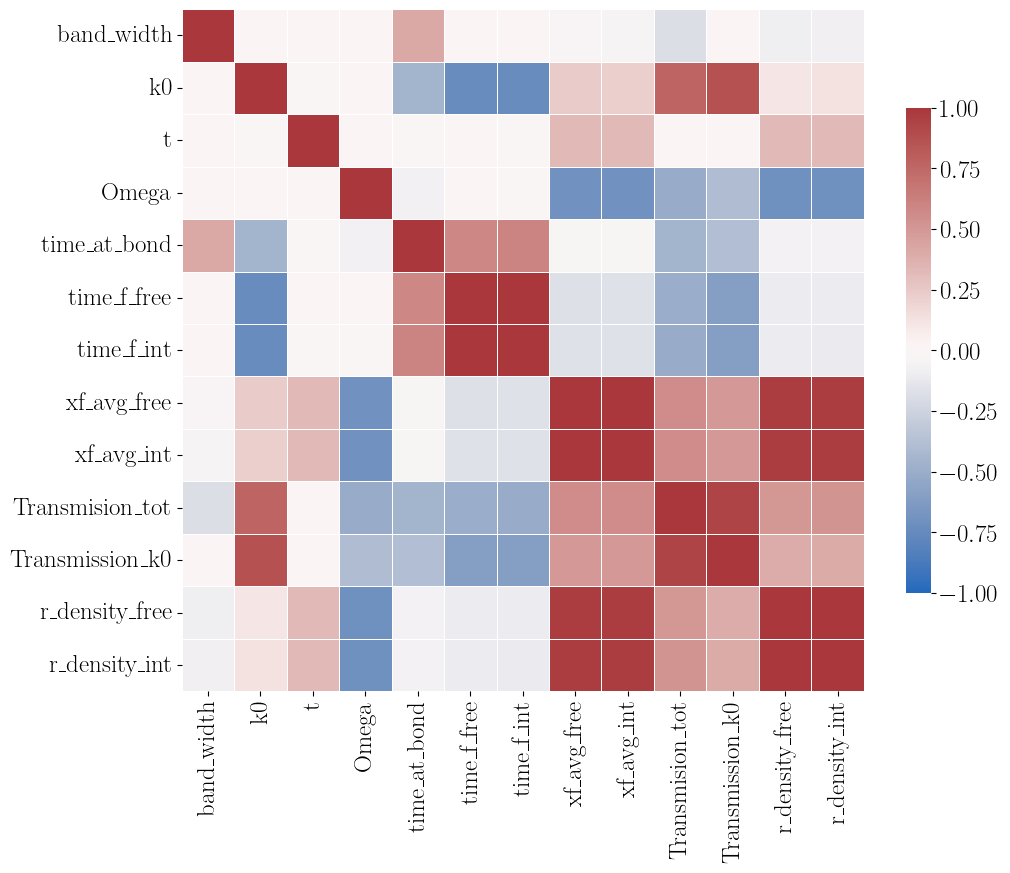

In [7]:
corr = data_df[rel_params+rel_results].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, square=True, linewidths=.5, vmin=-1, vmax=1 ,cmap = "vlag",cbar_kws={"shrink": .7})


plt.savefig(fig_route+"correlations.pdf")



## Time at bond

<Axes: xlabel='time_at_bond', ylabel='Count'>

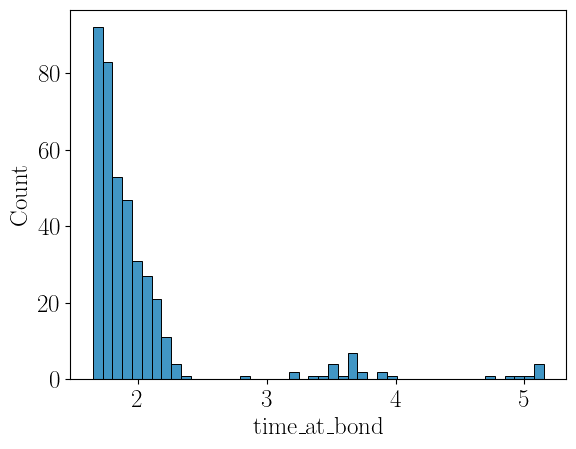

In [8]:
sns.histplot(data=data_df , x='time_at_bond')

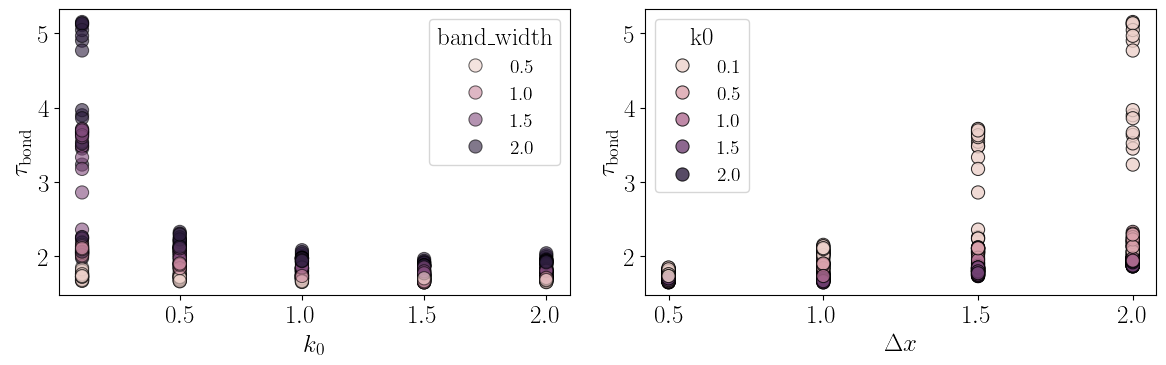

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(data=data_df, x="k0", y="time_at_bond",hue="band_width" , s=90,alpha=0.6,edgecolor='black',
                ax=ax[0])
sns.scatterplot(data=data_df, x="band_width", y="time_at_bond",hue="k0" ,s=90,alpha=0.8,edgecolor='black',
               ax=ax[1])

ax[0].set_xlabel(r"$k_0$")
ax[0].set_ylabel(r"$\tau_{\rm{bond}}$")

ax[1].set_xlabel(r"$\Delta x$")
ax[1].set_ylabel(r"$\tau_{\rm{bond}}$")
plt.tight_layout()

# plt.savefig(fig_route+"hitting_time_k0.pdf")



<Axes: xlabel='band_width', ylabel='k0'>

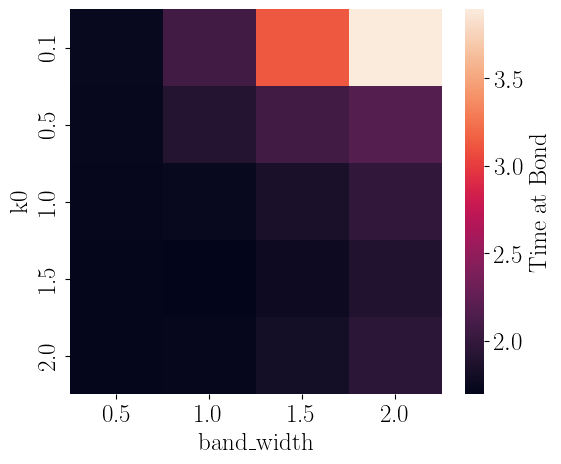

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

bondmap = data_df.pivot_table(index="k0", columns="band_width", values="time_at_bond")

sns.heatmap(bondmap,cbar_kws={'label': "Time at Bond"})


## Hitting time

make a density plot to get the correlations between the sim parameters and observed values. 
To see some kinf of relationship between the values we probably have to work by keeping one parameter or more parameter constant and then varying the rest, We can use hues for this.

Compare the time_last_density with the other two estimated times.
Also look at the maximum average x

1. Distringuish between values of omega and dot hopping because these change everything
2. compare the two estimated times with the density time
3. compare the maximum average x ant the group velocity x
4. compare the transmission coeffients


<Axes: xlabel='band_width', ylabel='k0'>

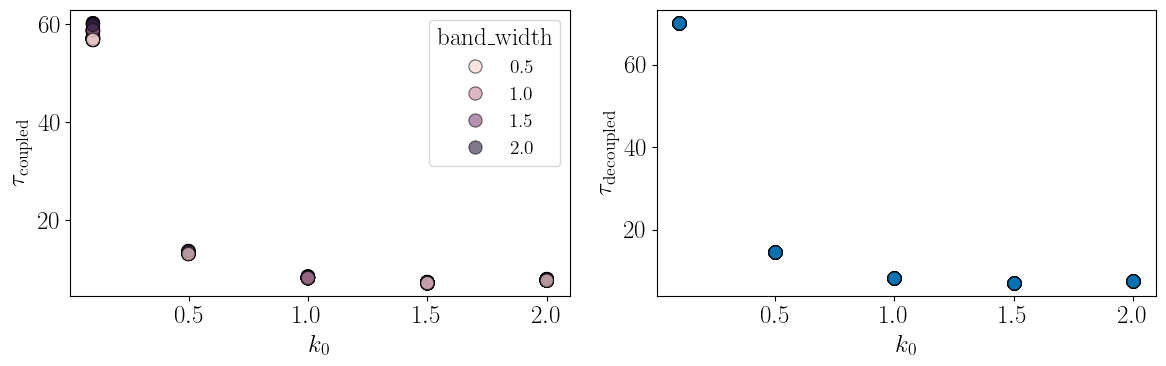

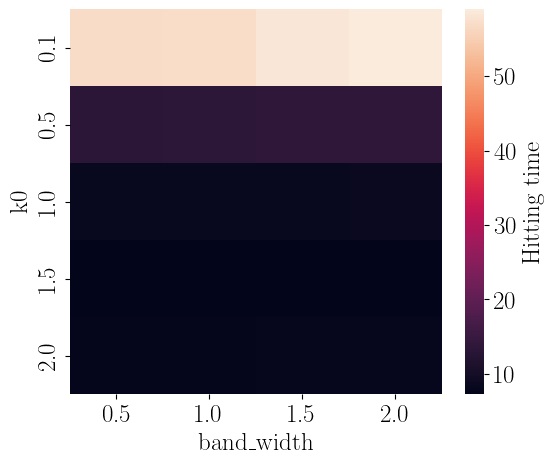

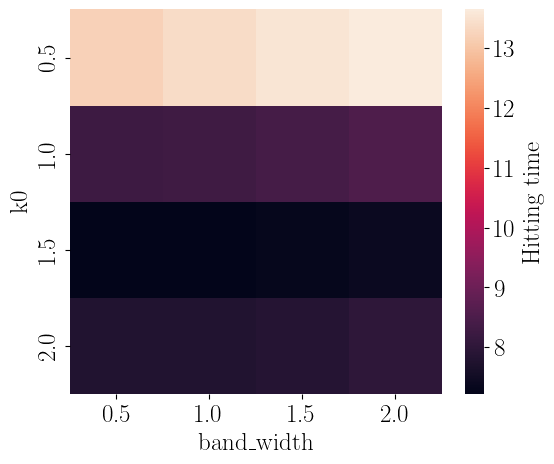

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.scatterplot(data=data_df, x="k0", y="time_f_int",hue="band_width" , s=90, alpha=0.6,edgecolor='black',
                ax=ax[0])
sns.scatterplot(data=data_df, x="k0", y="time_f_free",s=90,alpha=0.8,edgecolor='black',
               ax=ax[1])

ax[0].set_xlabel(r"$k_0$")
ax[0].set_ylabel(r"$\tau_{\rm{coupled}}$")

ax[1].set_xlabel(r"$k_0$")
ax[1].set_ylabel(r"$\tau_{\rm{decoupled}}$")
plt.tight_layout()

# plt.savefig(fig_route+"hitting_time_k0.pdf")

fig, ax = plt.subplots(1,1, figsize=(6,5))

bondmap = data_df.pivot_table(index="k0", columns="band_width", values="time_f_int")

sns.heatmap(bondmap,cbar_kws={'label': "Hitting time"})

# looking at values more in the semiclassical part

fig, ax = plt.subplots(1,1, figsize=(6,5))

bondmap = data_df[data_df['k0']>0.1].pivot_table(index="k0", columns="band_width", values="time_f_int")

sns.heatmap(bondmap,cbar_kws={'label': "Hitting time"})

## Entanglement

In [13]:
# build times array
ll = len(literal_eval(data_df["purity"].iloc[0]))
times_coarse = np.linspace(0,data_df["max_time"].unique()[0], ll)

constant omega, constant t constant bandwidth so we can look at **varying $k_0$**

Text(0, 0.5, 'VN Entropy')

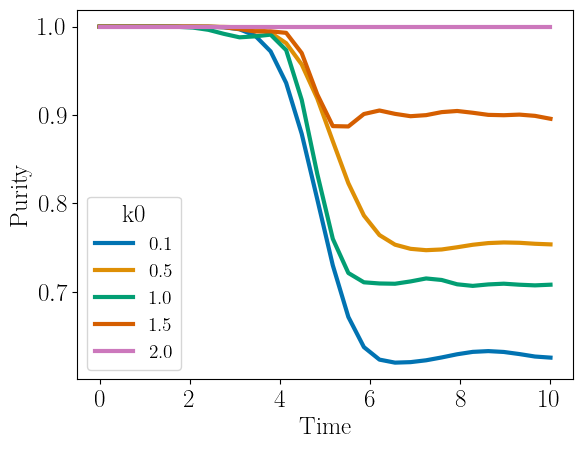

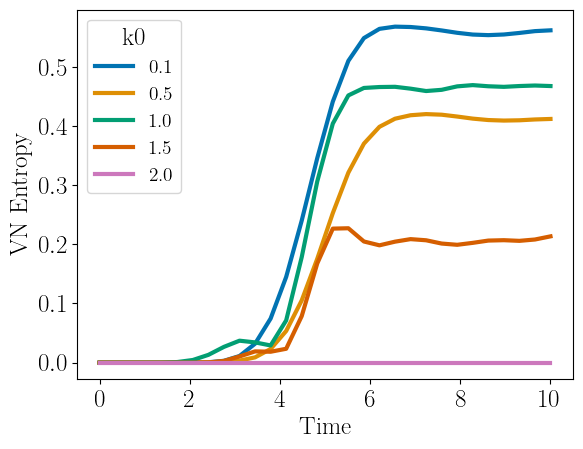

In [14]:
cond = (data_df['Omega']==0.5) & (data_df['band_width']==2.0) & (data_df['t']==0.2) 
curr_df = data_df[cond].sort_values(by="k0")

plt.figure()
for i in range(0,len(curr_df)):
    plt.plot(times_coarse, literal_eval(curr_df["purity"].iloc[i]), label=curr_df["k0"].iloc[i], linewidth=3.0)
    
plt.legend(title='k0')
plt.xlabel("Time")
plt.ylabel("Purity")

plt.figure()
for i in range(0,len(curr_df)):
    plt.plot(times_coarse, literal_eval(curr_df["VN_entropy"].iloc[i]), label=curr_df["k0"].iloc[i], 
             linewidth=3.0)
    
plt.legend(title='k0')
plt.xlabel("Time")
plt.ylabel("VN Entropy")


# Transmision probability

Average the transmision probability from 6 to 10 to get rid of those finite size effects and pick a values tht makes a bit more sense

<Axes: xlabel='k0', ylabel='T_mean'>

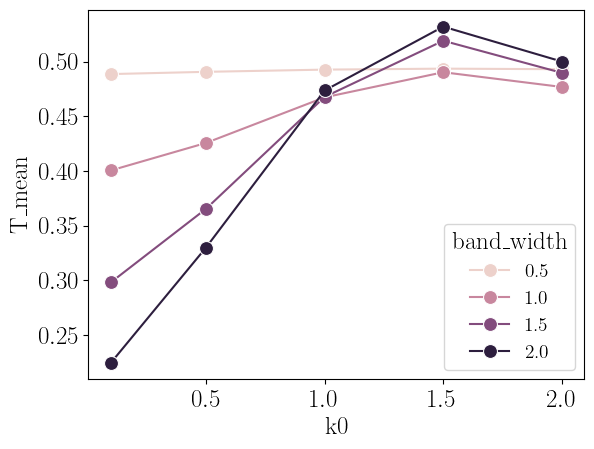

In [15]:
plt.figure()

cond = (data_df['Omega']==0.5) & (data_df['t']==0.0)
curr_df = data_df[cond].sort_values(by="k0")
sns.lineplot(data = curr_df, x="k0", y="T_mean", hue="band_width", marker='o', markersize=10)


# Individual examples

Test with the analytic scattering aplitude

In [130]:
# weak coupling well defined trajectory
"res_L14_maxtim10.0_bw2.0_k2.0_jp1.0_t0.0_om0.1_dd0second.hdf5"
# medium coupling well defined trajectory
"res_L14_maxtim10.0_bw2.0_k2.0_jp1.0_t0.0_om0.5_dd0second.hdf5"
# stronge coupling well defined trajectory
"res_L14_maxtim10.0_bw2.0_k2.0_jp1.0_t0.0_om0.7_dd0second.hdf5"

# weak coupling badly trajectory
"res_L14_maxtim10.0_bw0.1_k0.1_jp1.0_t0.0_om0.1_dd0second.hdf5"

# med coupling badly trajectory
"res_L14_maxtim10.0_bw0.1_k0.1_jp1.0_t0.0_om0.5_dd0second.hdf5"

file_name = "res_L19_maxtim9.0_bw2.0_k1.0_jp1.0_t0.5_om0.3_dd0second.hdf5"

param_dict, times, n_bond, n_left, n_right, n_last, n_d1, n_d2, traject = load_data(data_route,file_name)
J=1

# calculate data for the time scales
tau_L, tau_free, tau_b, vg, x_av, bond_root  = get_timescale_data(param_dict, traject, times, n_bond)                        
xvg = vg*times # trajectory using group velocity


## Timescales of the system

Three different times: time it takes to reach the bond, time spent at bond and time to gor from bond to the end.

The time at the bond is found as the full width at half-maximum of the bond occupations. The others are approximated as a freely propagating wave with the grpup velocity of the tight binding chain

For full width at half max: https://stackoverflow.com/questions/10582795/finding-the-full-width-half-maximum-of-a-peak

### For Science Slam

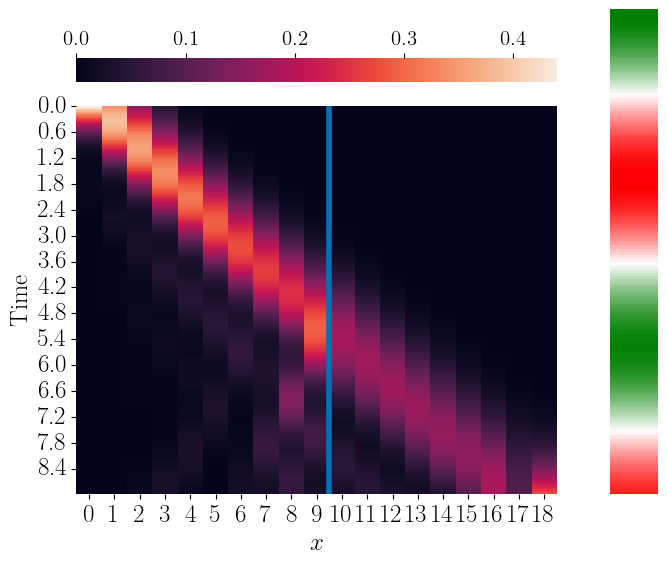

In [131]:
from  matplotlib.colors import LinearSegmentedColormap

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=100) 

# plot the occupations as a heatmap with lattice site in the y axis and time on the x
fig, ax = plt.subplots(1,2,figsize=(7.5,6.3), gridspec_kw={'width_ratios': [1, 0.1]})

sns.heatmap(traject[-2:-1].T,cbar=None, ax=ax[1], cmap=cmap)
ax[1].set_xticks([]),
ax[1].set_yticks([])


sns.heatmap(traject[:-2].T,ax=ax[0], cbar_kws = dict(use_gridspec=False,location="top"))
ax[0].set_ylabel("Time")
ax[0].set_xlabel(r"$x$")
ax[0].axvline(param_dict["bond_index"]+1, linewidth=4)

# cbar ticks
cbar = ax[0].collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

# lattice ticks
site_ticks = list(range(0,param_dict["L_qpc"])) 
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax[0].set_xticks(tick_posy,site_ticks);

# time ticks
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax[0].set_yticks(tick_posx,xtick_label);

plt.savefig("../frog_hop.png", dpi = 400)

estimated time to hit the far wall with coupling:  11.534301879266746
estimated time to hit the far wall without coupling:  11.289753504892152


'plt.savefig(fig_route+"traj_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.png".format(\n            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],\n            param_dict["J_prime"], param_dict["Omega"]))'

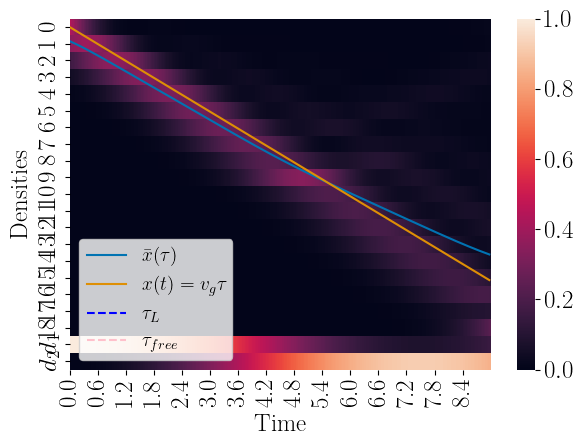

In [37]:

print("estimated time to hit the far wall with coupling: ", tau_L)
print("estimated time to hit the far wall without coupling: ", tau_free)


# plot the occupations as a heatmap with lattice site in the y axis and time on the x
ax = sns.heatmap(traject,)
ax.set_xlabel("Time")
ax.set_ylabel("Densities")
plt.plot(x_av+0.5,label=r"$\bar{x}(\tau)$") # the 0.5 is so the values correspond to the ticks so its easier to visualize
plt.plot(xvg+0.5, label= r"$x(t)=v_g \tau$")
# plot time or arrival in index coordinates
delta_tau = times[1]- times[0]
ax.axvline(tau_L/delta_tau, label=r"$\tau_{L}$", linestyle="dashed", c='blue')
ax.axvline(tau_free/delta_tau, label=r"$\tau_{free}$", linestyle="dashed", c="pink")

#ax.axhspan(param_dict["bond_index"], param_dict["bond_index"], alpha=0.5)

# lattice ticks
site_ticks = list(range(0,param_dict["L_qpc"])) + [r"$d_1$",r"$d_2$"]
tick_posy = np.asarray(range(0,len(site_ticks))) + 0.5
ax.set_yticks(tick_posy,site_ticks);

# time ticks
tick_posx = np.arange(0,len(times),20)
xtick_label = np.around(tick_posx*(delta_tau),decimals=1)
ax.set_xticks(tick_posx,xtick_label);

plt.legend(loc='lower left')
plt.tight_layout()

"""plt.savefig(fig_route+"traj_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.png".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))"""



In [ ]:
fig, ax = plt.subplots(2,1, figsize=(7,5),sharex=True)
wr = param_dict["t"]
rabi_osc = np.sin(wr*times)**2

# in dot
ax[0].plot(times, rabi_osc, linewidth=2.0, alpha=1.0, c='black' ,label="d2")
ax[0].plot(times, traject[-1], linewidth=2.0, alpha=1.0, linestyle="dashed" ,label="d2")
ax[0].plot(times, traject[-2], linewidth=2.0, alpha=1.0, label="d1")

ax[1].plot(times, n_left, label="Left", c='blue', linewidth=2)
ax[1].plot(times,n_right,label="Right", c='green',linewidth=2)
ax[1].plot(times,n_bond,label="Bond", linestyle="dashed", c='red',linewidth=2)
ax[1].plot(times,n_last,label="last site", linestyle="dotted",linewidth=2)
ax[1].plot(times,n_left+n_right+n_bond, c = 'black'
        ,linewidth=2)

# plot full width at half maximum at bond
ax[1].axvspan(bond_root[0], bond_root[1], facecolor='r', alpha=0.45)

ax[0].legend()
ax[0].set_ylabel("Double dot densities")

ax[1].set_xlabel("time")
ax[1].set_ylabel("QPC densities")
ax[1].legend()




## Comparisson with Scattering Calculations

For small enough $t$ (double dot hopping) we can approximate the bond pottential as a constant delta function potential. Therefore we can compare to some analytical results using scattering 

In [ ]:
T0, T_tot = get_transmision_proba(param_dict, J)


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

plt.plot(times, n_right,linewidth=2)

ax.axhline(T0, linestyle='dashed',c="black", label= r"$T(k_0)$", linewidth=2)
ax.axhline(T_tot, linestyle='solid',c="red", label= r"$T_{tot}$", linewidth=2)

ax.axvline(tau_L, label=r"$\tau_{L}$", linestyle="dashed", c='blue')
ax.axvline(tau_free, label=r"$\tau_{free}$", linestyle="dashed", c="pink")

plt.ylim(-0.02,1.02)
#plt.xlim(min(times),max(times))


plt.xlabel('Time')
plt.ylabel("Densities")
plt.legend()

plt.tight_layout()
"""
plt.savefig(fig_route+"scattering_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))
"""


# Constant $t$ , $k$ and variable $\Omega$

here we always look at $\Omega = {0.1, 0.5,1.0 }$


In [ ]:
Lqpc = 14
maxtime = 10.0
bw = 1.5
k0 = 2.0
jp = 1.0
t = 0.2
dd_init = "second"
file_list = [
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.1_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om0.5_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            "res_L{}_maxtim{}_bw{}_k{}_jp{}_t{}_om1.0_dd0{}.hdf5".format(Lqpc,maxtime,bw,k0,jp,t,dd_init), 
            ]


In [ ]:
colors = plt.cm.Blues(np.linspace(0.4,1,len(file_list)))

tick_positions = []
omega_labels = []

fig, axd = plt.subplots(2,1,figsize=(6,7),sharex=True)

for f in range(0,len(file_list)):
    file_ = file_list[f]
    # for the double dots
    param_dict, times, n_bond, n_left, n_right, n_last, n_d1, n_d2, traject = load_data(data_route, file_)
    Om = param_dict["Omega"]
    
    print(param_dict)
    
    axd[0].plot(times, n_d2, c = colors[f], alpha=0.8 ,linewidth=2.5, 
                label=r'$\Omega={}$'.format(param_dict["Omega"]))    
    
    axd[1].plot(times,n_last+(2.5*Om), linestyle="dotted",linewidth=2,c='black')
    axd[1].plot(times, n_left+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,)
    axd[1].plot(times, n_right+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashed")
    axd[1].plot(times, n_bond+(2.5*Om), c = colors[f], alpha=1.0 ,linewidth=2.5,linestyle="dashdot")

    tick_positions.append(2.5*Om+0.5)
    omega_labels.append(Om)  
    
    # for the trajectories ----------------
    fig_traj, ax_traj = plt.subplots(1,1,figsize=(7.0,6))
    
    # plot the occupations as a heatmap with lattice site in the y axis and time on the x
    sns.heatmap(traject, ax=ax_traj)
    ax_traj.set_xlabel("steps")
    ax_traj.set_ylabel("densities")
    ax_traj.axhline(param_dict["bond_index"]+1,c='blue')

    site_ticks = list(range(0,13)) + ["d1","d2"]
    tick_pos = np.asarray(range(0,15)) + 0.5

    ax_traj.set_yticks(tick_pos,site_ticks);
    fig_traj.tight_layout()
    """fig_traj.savefig("../plots/QPC_double_dot/traj_L={:.2f}_tdot={:.2f}_K={}_Jp={}_dd_{}_om={}.png".format(Lqpc, t, k0,jp,
                                                                                                           dd_init,Om),
                         dpi=400)"""
    
axd[1].plot(0,0,linestyle="dotted",linewidth=2.0,label='Last', c='black')
axd[1].plot(0,0,linestyle="solid",linewidth=2.5,label='Left', c=colors[1])
axd[1].plot(0,0,linestyle="dashed",linewidth=2.5,label='Right',c=colors[1])
axd[1].plot(0,0,linestyle="dashdot",linewidth=2.5,label='bond',c=colors[1])


# analytic expectation for decoupled case
rabi_osc = np.sin(t*times)**2

axd[0].plot(times, rabi_osc, linewidth=5, alpha=0.8, c='red' ,label=r"$\Omega = 0$",zorder=0)

axd[0].set_title(r"$t = {}, k = {}, J_p={}$".format(t,k0, jp))
axd[0].legend()
axd[0].set_ylabel(r"$n_{d1}$")
axd[0].set_box_aspect(1/3.5)
axd[0].xaxis.set_ticks_position('none') 

axd[1].set_xlabel(r"Time")
axd[1].set_ylabel(r"$\Omega / n_{s}$")
axd[1].set_yticks(tick_positions, omega_labels)
axd[1].legend()
fig.subplots_adjust(hspace=-0.62)


"""fig.tight_layout()
fig.savefig("../plots/QPC_double_dot/density_sums_L={:.2f}_tdot={:.2f}_K={}_Jp={}_bw={}_dd_{}.pdf".format(Lqpc, t,
                                                                                                 k0,jp,bw,dd_init))
"""